## Constants

In [71]:
IMPORT_PATH = '../data/processed/TrainValid_clean.csv'
IMPORT_VALID = '../data/raw/Valid.csv'
IMPORT_VALID_SOL = '../data/raw/ValidSolution.csv'
MODEL_SAVE = '../models/model.pkl'

## Import tools

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

## Import data set

In [4]:
df = pd.read_csv(IMPORT_PATH)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,2006,11,...,0,0,0,0,0,0,0,0,4,2
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,2004,3,...,0,0,0,0,0,0,0,0,4,2
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,2004,2,...,0,0,0,0,0,0,0,0,0,0
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,2011,5,...,0,0,0,0,0,0,0,0,0,0
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,2009,7,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_copy = df.copy()

## Creating our score function

In [43]:
def rmsle(y_test, y_pred):
    """
    calculating the root mean square error between prediction and true values
    """

    return np.sqrt(mean_squared_log_error(y_test, y_pred))


def scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    scores = {'rmsle-train': rmsle(y_train, train_preds), 'rmsle-test': rmsle(y_test, test_preds),
            'MAE-train':mean_absolute_error(y_train, train_preds), 'MAE-test': mean_absolute_error(y_test, test_preds),
            'MSE-train':mean_squared_error(y_train, train_preds), 'MSE-test': mean_squared_error(y_test, test_preds),
            'R2-training': r2_score(y_train, train_preds), 'R2-test':r2_score(y_test, test_preds)}

    return scores


def scores_val(y_pred, y_test):

    scores = {'rmsle': rmsle(y_test, y_pred),
             'MAE': mean_absolute_error(y_test, y_pred),
             'MSE': mean_squared_error(y_test, y_pred),
             'R2':r2_score(y_test, y_pred)}

    return scores



## Split the data

In [33]:
df_copy = shuffle(df_copy)

In [34]:
y = df_copy.SalePrice
df_copy.drop('SalePrice', axis=1, inplace=True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_copy, y, test_size=0.3)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288888, 56), (123810, 56), (288888,), (123810,))

In [37]:
%%time
regressor = RandomForestRegressor(n_jobs=-1 , n_estimators=250)
regressor.fit(X_train, y_train)

Wall time: 5min 28s


RandomForestRegressor(n_estimators=250, n_jobs=-1)

In [38]:
model_scores = scores(regressor, X_train, X_test, y_train, y_test)

In [39]:
for i,j in model_scores.items():
    print(i + "  {}".format(j))


rmsle-train  0.08626833434984384
rmsle-test  0.21445125704937157
MAE-train  1639.239093497826
MAE-test  4449.746918588159
MSE-train  6962996.164573699
MSE-test  50905315.84554212
R2-training  0.986985045959566
R2-test  0.9051678372317719


# Test the model on validation data set

In [59]:
# Make a processing function to convert the validation dataframe to trained dataframe

def process_df(df_pass):

    df = df_pass.copy()
    # Adding the new data columns
    df['saleYear'] = pd.DatetimeIndex(df.saledate).year
    df['saleMonth'] = pd.DatetimeIndex(df.saledate).month
    df['saleDay'] = pd.DatetimeIndex(df.saledate).day
    df['saleDayOfWeek'] = pd.DatetimeIndex(df.saledate).dayofweek
    df['saleDayOfYear'] = pd.DatetimeIndex(df.saledate).dayofyear
    df.drop('saledate', axis=1, inplace=True)


    num_df = df.select_dtypes(exclude='object')
    cat_df = df.select_dtypes(include='object')

    # Clean the numerical columns

    for col in num_df.columns:
         num_df[col].fillna(num_df[col].median(), inplace=True)


    # Convert the string columns into categorical

    for col in cat_df.columns:
        if pd.api.types.is_string_dtype(cat_df[col]):
          cat_df[col] = cat_df[col].astype('category')


    # Clean the categorical columns

    for col in cat_df.columns:
      cat_df[col] = pd.Categorical(cat_df[col]).codes + 1


    final_df = pd.concat([num_df, cat_df], axis=1)


    return final_df


## Read the data

In [60]:
valid_df = pd.read_csv(IMPORT_VALID)
valid_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1222837,902859,1376,121,3,1000,0.0,NaN,1/5/2012 0:00,375L,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,1/5/2012 0:00,TX300LC2,...,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN
2,1222841,999308,4587,121,3,2000,10127.0,Medium,1/5/2012 0:00,270LC,...,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1222843,1062425,1954,121,3,1000,4682.0,Low,1/5/2012 0:00,892DLC,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,1/4/2012 0:00,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [61]:
valid_copy = process_df(valid_df)
valid_copy.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1222837,902859,1376,121,3,1000,0.0,2012,1,5,...,16,21,3,2,1,0,0,0,0,0
1,1222839,1048320,36526,121,3,2006,4412.0,2012,1,5,...,16,7,3,3,1,0,0,0,0,0
2,1222841,999308,4587,121,3,2000,10127.0,2012,1,5,...,16,7,3,2,1,0,0,0,0,0
3,1222843,1062425,1954,121,3,1000,4682.0,2012,1,5,...,16,21,3,2,1,0,0,0,0,0
4,1222845,1032841,4701,121,3,2002,8150.0,2012,1,4,...,0,0,0,0,0,0,0,0,3,2


In [62]:
valid_sol = pd.read_csv(IMPORT_VALID_SOL)
valid_sol.head()

,SalesID,SalePrice,Usage
0,1222837,31000.0,PublicTest
1,1222839,54000.0,PublicTest
2,1222841,26500.0,PublicTest
3,1222843,10000.0,PublicTest
4,1222845,35000.0,PublicTest


### Test tha validation

In [63]:
valid_pred = regressor.predict(valid_copy)

In [64]:
val_scores = scores_val(valid_sol.SalePrice, valid_pred)

In [65]:
for i,j in val_scores.items():
    print(i + "  {}".format(j))


rmsle  0.46915179674338736
MAE  10517.592044793915
MSE  334617524.5550983
R2  0.23007084196393035


## Feature importance

In [84]:
def plot_feature_importance(columns, feature_importance, n):

    df = pd.DataFrame({'Features': columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots()
    ax.barh(df['Features'][:n], df['Importance'][:n])
    ax.set_ylabel("Importance")
    ax.set_xlabel('Features')
    ax.invert_yaxis()

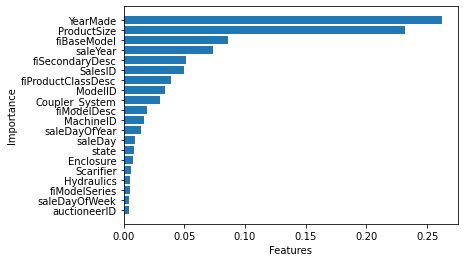

In [85]:
plot_feature_importance(X_train.columns, regressor.feature_importances_, 20)

## Save the model 

In [72]:
pickle.dump(regressor, open(MODEL_SAVE, 'wb'))